## Data Understanding

                        date                   id  \
0  2022-11-30 04:17:49+00:00  1597807084934172672   
1  2022-11-30 02:48:10+00:00  1597784522728558592   
2  2022-11-29 17:21:57+00:00  1597642029479038976   
3  2022-11-29 11:40:40+00:00  1597556142213070850   
4  2022-11-29 10:12:57+00:00  1597534071202385922   

                                             content         username  \
0  📌 @elonmusk begins hiring for Twitter 2.0 afte...  workflexitweets   
1  Global Recession से दुनिया हुई बेहाल, लेकिन In...        indilinks   
2  Will global recession impact India or not? #re...     BizzBuzzNews   
3  Is Recession In India Coming Soon?\n\nWant to ...  Anubhav74782862   
4  A report by #realestate data collation &amp; r...    indiaoutbound   

   likeCount  retweetCount  
0          1             1  
1          0             0  
2          0             0  
3          0             0  
4          1             0  
date            0
id              0
content         0
username      

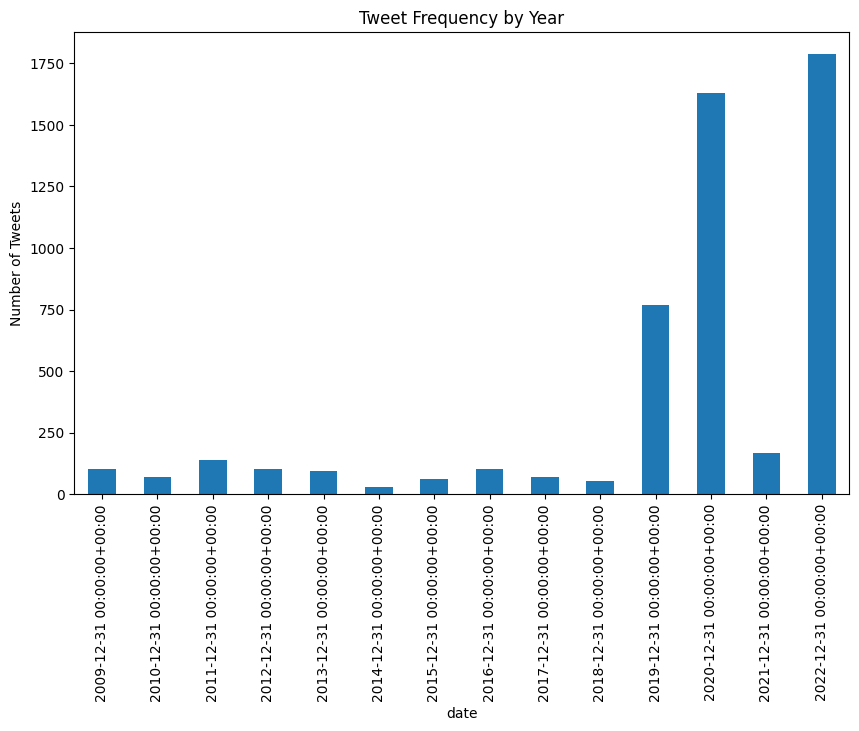

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('recession_2023_india_tweets_dataset.csv')

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Check column names to ensure they are correct
print(df.columns)

# Strip any extra spaces from the column names (if any)
df.columns = df.columns.str.strip()

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Check if the index is set correctly
print(df.index)

# Add a helper column to count tweets
df['tweet_count'] = 1

# Resample the data by year and count the number of tweets per year
yearly_tweet_counts = df['tweet_count'].resample('Y').sum()

# Plot the tweet frequency by year
plt.figure(figsize=(10, 6))
yearly_tweet_counts.plot(kind='bar', title='Tweet Frequency by Year')
plt.ylabel('Number of Tweets')
plt.show()

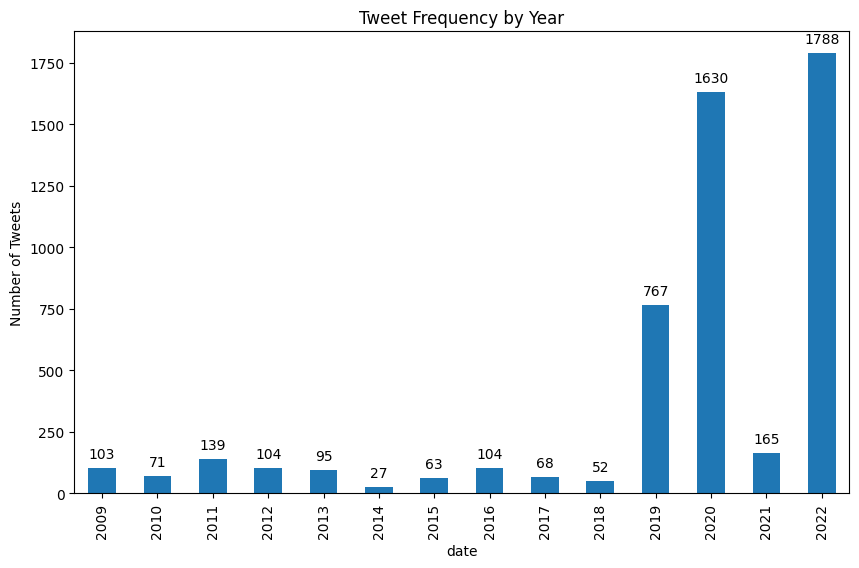

In [2]:
# Plot the tweet frequency by year with years on the x-axis and counts on top of the bars
plt.figure(figsize=(10, 6))
ax = yearly_tweet_counts.plot(kind='bar', title='Tweet Frequency by Year')

# Set x-axis labels to just the year
ax.set_xticklabels([date.strftime('%Y') for date in yearly_tweet_counts.index])

# Add counts on top of each bar
for p in ax.patches:
    ax.annotate(str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.ylabel('Number of Tweets')
plt.show()

## Data Preparation

In [3]:
import re
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Load SpaCy's English model
nlp = spacy.load('en_core_web_sm')

# Function to clean tweets
def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply cleaning function to the content column
df['cleaned_content'] = df['content'].apply(clean_tweet)

# Tokenization and lemmatization function
def tokenize_and_lemmatize(text):
    doc = nlp(text)
    # Lemmatize and remove stop words
    return ' '.join([token.lemma_ for token in doc if not token.is_stop])

# Apply tokenization and lemmatization to the cleaned content
df['lemmatized_content'] = df['cleaned_content'].apply(tokenize_and_lemmatize)

# Display the processed data
print(df[['content', 'cleaned_content', 'lemmatized_content']].head())

# Splitting data into training and testing sets
X = df['lemmatized_content']
y = df['likeCount']  # Predicting the like count as a proxy for sentiment

# Splitting the data: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorizing the text data using CountVectorizer
vectorizer = CountVectorizer(max_features=1000)
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Display the shape of the resulting vectors
print(f'Training data shape: {X_train_vect.shape}')
print(f'Testing data shape: {X_test_vect.shape}')


                                                                     content  \
date                                                                           
2022-11-30 04:17:49+00:00  📌 @elonmusk begins hiring for Twitter 2.0 afte...   
2022-11-30 02:48:10+00:00  Global Recession से दुनिया हुई बेहाल, लेकिन In...   
2022-11-29 17:21:57+00:00  Will global recession impact India or not? #re...   
2022-11-29 11:40:40+00:00  Is Recession In India Coming Soon?\n\nWant to ...   
2022-11-29 10:12:57+00:00  A report by #realestate data collation &amp; r...   

                                                             cleaned_content  \
date                                                                           
2022-11-30 04:17:49+00:00    begins hiring for twitter 20 after firing ne...   
2022-11-30 02:48:10+00:00  global recession स दनय हई बहल लकन india न कर ड...   
2022-11-29 17:21:57+00:00     will global recession impact india or not        
2022-11-29 11:40:40+00:00  is recession

## 4. Modeling

In [4]:
pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [5]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment
def classify_sentiment(text):
    scores = analyzer.polarity_scores(text)
    compound_score = scores['compound']
    if compound_score >= 0.05:
        return 2  # Positive
    elif compound_score <= -0.05:
        return 0  # Negative
    else:
        return 1  # Neutral

# Apply sentiment analysis to the 'lemmatized_content' column
df['sentiment_label'] = df['lemmatized_content'].apply(classify_sentiment)

# Display the first few rows to check the sentiment labels
print(df[['lemmatized_content', 'sentiment_label']].head())

# Check the column names to ensure 'date' exists and is correctly named
print(df.columns)

                                                          lemmatized_content  \
date                                                                           
2022-11-30 04:17:49+00:00     begin hire twitter 20 fire nearly 5000 empl...   
2022-11-30 02:48:10+00:00  global recession स दनय हई बहल लकन india न कर ड...   
2022-11-29 17:21:57+00:00                 global recession impact india        
2022-11-29 11:40:40+00:00  recession india come soon \n\n want know read ...   
2022-11-29 10:12:57+00:00  report   datum collation amp research firm   s...   

                           sentiment_label  
date                                        
2022-11-30 04:17:49+00:00                0  
2022-11-30 02:48:10+00:00                0  
2022-11-29 17:21:57+00:00                0  
2022-11-29 11:40:40+00:00                0  
2022-11-29 10:12:57+00:00                1  
Index(['id', 'content', 'username', 'likeCount', 'retweetCount', 'tweet_count',
       'cleaned_content', 'lemmatized_conten

In [6]:
# Check the column names to ensure 'date' exists and is correctly named
print(X)

date
2022-11-30 04:17:49+00:00       begin hire twitter 20 fire nearly 5000 empl...
2022-11-30 02:48:10+00:00    global recession स दनय हई बहल लकन india न कर ड...
2022-11-29 17:21:57+00:00                   global recession impact india     
2022-11-29 11:40:40+00:00    recession india come soon \n\n want know read ...
2022-11-29 10:12:57+00:00    report   datum collation amp research firm   s...
                                                   ...                        
2009-03-16 11:32:55+00:00              india beat recession blue fdi radar    
2009-03-03 18:06:09+00:00                 lakh indian return home india year  
2009-02-26 03:51:33+00:00    puneet doubt economy bric insulate   report in...
2009-02-02 16:26:53+00:00                          wow guy ms india search job
2009-01-14 11:30:24+00:00    indian abandon car   airport   tighten    indi...
Name: lemmatized_content, Length: 5176, dtype: object


<ipython-input-7-ed6d9a994070>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")


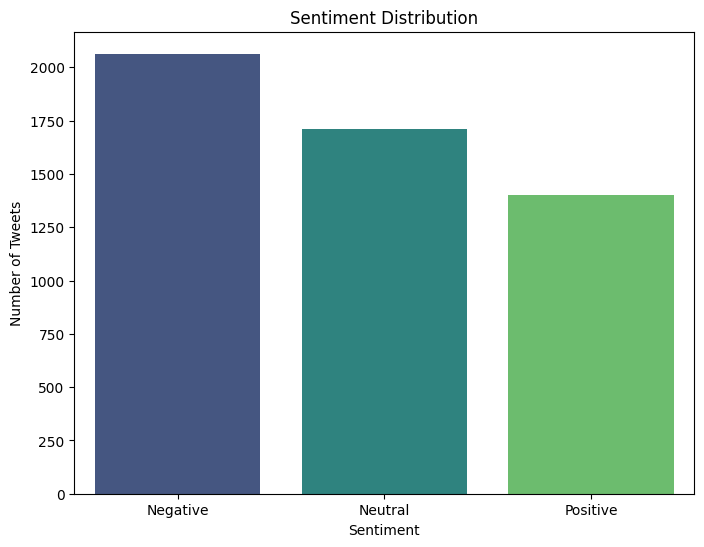

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each sentiment
sentiment_counts = df['sentiment_label'].value_counts()

# Plot the distribution of sentiments
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

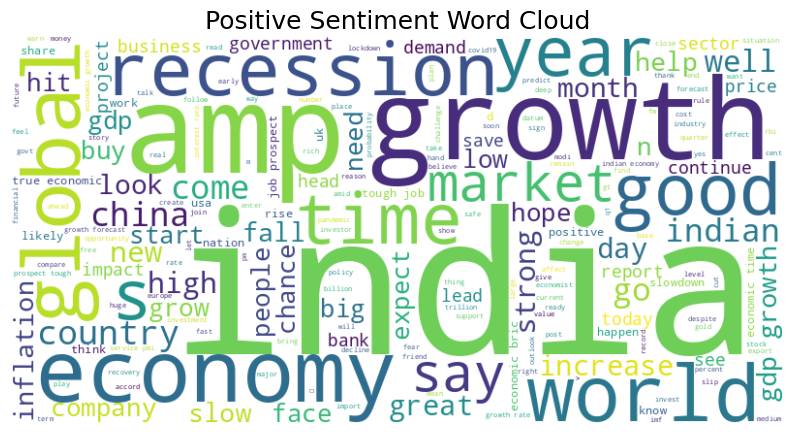

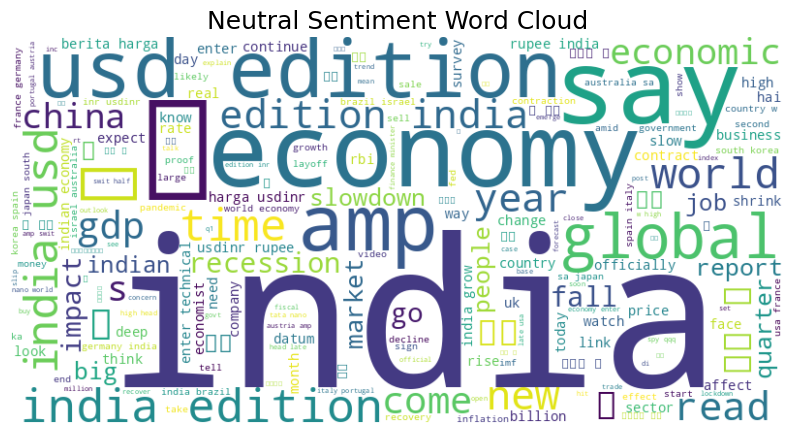

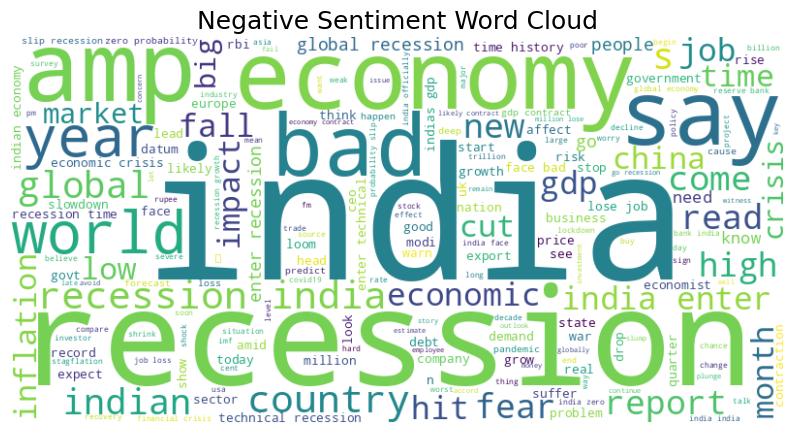

In [8]:
from wordcloud import WordCloud

# Function to generate a word cloud
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(data))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=18)
    plt.axis('off')
    plt.show()

# Generate word clouds for each sentiment
positive_tweets = df[df['sentiment_label'] == 2]['lemmatized_content']
neutral_tweets = df[df['sentiment_label'] == 1]['lemmatized_content']
negative_tweets = df[df['sentiment_label'] == 0]['lemmatized_content']

generate_wordcloud(positive_tweets, 'Positive Sentiment Word Cloud')
generate_wordcloud(neutral_tweets, 'Neutral Sentiment Word Cloud')
generate_wordcloud(negative_tweets, 'Negative Sentiment Word Cloud')

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from sklearn.model_selection import train_test_split

# Adjust the number of labels for the multi-class classification task
num_labels = 3  # For multi-class classification

# Load the smaller DistilBERT tokenizer and model for faster training
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

# Tokenize the data with a smaller max_length to reduce computation time
def tokenize_function(texts, max_seq_length=128):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_seq_length)

# Example assuming df contains lemmatized content and sentiment labels
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_content'], df['sentiment_label'], test_size=0.2, random_state=42)

# Sample 1000 indices to ensure X_train_small and y_train_small are aligned
sampled_indices = X_train.sample(1000, random_state=42).index

# Use these indices to create the small training dataset
X_train_small = X_train.loc[sampled_indices]
y_train_small = y_train.loc[sampled_indices]

# Tokenize the smaller datasets
train_encodings = tokenizer(X_train_small.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

# Debugging: Check the lengths of encodings and labels again
print("Length of train_encodings:", len(train_encodings['input_ids']))
print("Length of y_train_small:", len(y_train_small))

# Convert to torch datasets
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

        # Ensure that encodings and labels have the same length
        assert len(self.encodings['input_ids']) == len(self.labels), "Encodings and labels must have the same length"

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create train and test datasets
train_dataset = TweetDataset(train_encodings, y_train_small.tolist())
test_dataset = TweetDataset(test_encodings, y_test.tolist())

# Check if a GPU is available and use it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training arguments (including optimizations for faster training)
training_args = TrainingArguments(
    output_dir='./results',            # Output directory
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=8,      # Batch size for evaluation
    warmup_steps=500,                  # Warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir='./logs',              # Directory for logs
    evaluation_strategy="epoch",       # Evaluate after each epoch
    save_strategy="epoch",             # Save the model after each epoch
    fp16=True,                         # Enable mixed precision training (faster on supported hardware)
    gradient_accumulation_steps=4,     # Accumulates gradients over multiple steps to simulate a larger batch size
    load_best_model_at_end=True        # Save and load the best model at the end of training
)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model after training
model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Length of train_encodings: 1002
Length of y_train_small: 1002


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,1.091637
2,No log,0.934865


('./saved_model/tokenizer_config.json',
 './saved_model/special_tokens_map.json',
 './saved_model/vocab.txt',
 './saved_model/added_tokens.json')

Classification Report:
              precision    recall  f1-score   support

    Negative       0.54      0.93      0.68       430
     Neutral       0.81      0.49      0.61       336
    Positive       0.52      0.18      0.27       270

    accuracy                           0.59      1036
   macro avg       0.63      0.53      0.52      1036
weighted avg       0.62      0.59      0.55      1036



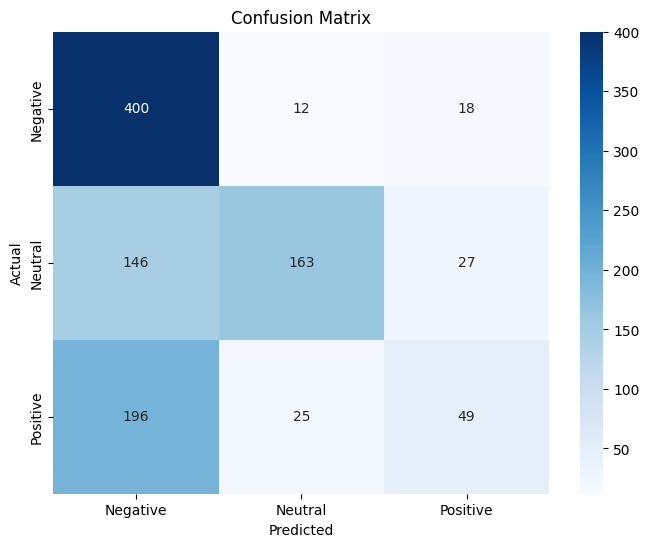

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get the index of the highest logit

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LSTM Implementation

Epoch 1/5, Loss: 1.104796290397644
Epoch 2/5, Loss: 1.0870075225830078
Epoch 3/5, Loss: 1.0698013305664062
Epoch 4/5, Loss: 1.0610158443450928
Epoch 5/5, Loss: 1.0816575288772583


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    Negative       0.42      1.00      0.59       430
     Neutral       0.00      0.00      0.00       336
    Positive       0.00      0.00      0.00       270

    accuracy                           0.42      1036
   macro avg       0.14      0.33      0.20      1036
weighted avg       0.17      0.42      0.24      1036



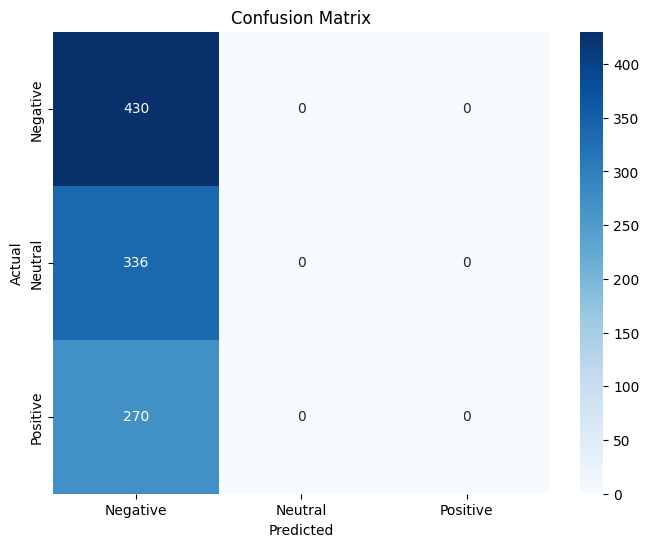

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Tokenize and Pad the Data (using the same tokenizer as before)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example assuming df contains lemmatized content and sentiment labels
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_content'], df['sentiment_label'], test_size=0.2, random_state=42)

# Tokenizer
vocab_size = 10000
max_length = 128
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Convert text to sequences and pad them
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create Dataset and DataLoader
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SentimentDataset(X_train_tensor, y_train_tensor)
test_dataset = SentimentDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the last time step output
        out = self.fc(lstm_out)
        return out

# Hyperparameters
hidden_dim = 128
output_dim = num_labels  # Assuming 3 classes (Negative, Neutral, Positive)

# Model, Loss, Optimizer
model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
epochs = 5

for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Evaluation
model.eval()
all_preds = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        output = model(X_batch)
        preds = torch.argmax(output, axis=1)
        all_preds.append(preds.cpu().numpy())

all_preds = np.concatenate(all_preds)
print(classification_report(y_test, all_preds, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion Matrix
cm = confusion_matrix(y_test, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## RoBERTa

In [12]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Adjust the number of labels for the multi-class classification task
num_labels = 3  # For multi-class classification

# Load the RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)

# Tokenize the data with a smaller max_length to reduce computation time
def tokenize_function(texts, max_seq_length=128):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_seq_length)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_content'], df['sentiment_label'], test_size=0.2, random_state=42)

# Sample 1000 indices to ensure X_train_small and y_train_small are aligned
sampled_indices = X_train.sample(1000, random_state=42).index

# Use these indices to create the small training dataset
X_train_small = X_train.loc[sampled_indices]
y_train_small = y_train.loc[sampled_indices]

# Tokenize the smaller datasets
train_encodings = tokenizer(X_train_small.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

# Debugging: Check the lengths of encodings and labels again
print("Length of train_encodings:", len(train_encodings['input_ids']))
print("Length of y_train_small:", len(y_train_small))

# Convert to torch datasets
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

        # Ensure that encodings and labels have the same length
        assert len(self.encodings['input_ids']) == len(self.labels), "Encodings and labels must have the same length"

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create train and test datasets
train_dataset = TweetDataset(train_encodings, y_train_small.tolist())
test_dataset = TweetDataset(test_encodings, y_test.tolist())

# Check if a GPU is available and use it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training arguments (including optimizations for faster training)
training_args = TrainingArguments(
    output_dir='./results_roberta',    # Output directory
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=8,      # Batch size for evaluation
    warmup_steps=500,                  # Warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir='./logs_roberta',      # Directory for logs
    evaluation_strategy="epoch",       # Evaluate after each epoch
    save_strategy="epoch",             # Save the model after each epoch
    fp16=True,                         # Enable mixed precision training (faster on supported hardware)
    gradient_accumulation_steps=4,     # Accumulates gradients over multiple steps to simulate a larger batch size
    load_best_model_at_end=True        # Save and load the best model at the end of training
)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model after training
model.save_pretrained('./saved_model_roberta')
tokenizer.save_pretrained('./saved_model_roberta')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Length of train_encodings: 1002
Length of y_train_small: 1002


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,1.125973
2,No log,0.866824


('./saved_model_roberta/tokenizer_config.json',
 './saved_model_roberta/special_tokens_map.json',
 './saved_model_roberta/vocab.json',
 './saved_model_roberta/merges.txt',
 './saved_model_roberta/added_tokens.json')

Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.62      0.66       430
     Neutral       0.79      0.58      0.67       336
    Positive       0.43      0.64      0.51       270

    accuracy                           0.61      1036
   macro avg       0.64      0.62      0.61      1036
weighted avg       0.66      0.61      0.63      1036



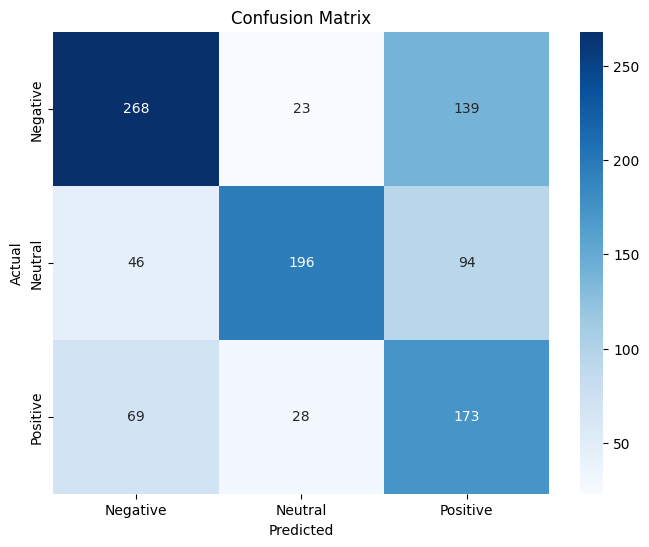

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get the index of the highest logit

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [14]:
from transformers import AlbertTokenizer, AlbertForSequenceClassification, Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split

# Adjust the number of labels for the multi-class classification task
num_labels = 3  # For multi-class classification

# Load the ALBERT tokenizer and model
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=num_labels)

# Tokenize the data with a smaller max_length to reduce computation time
def tokenize_function(texts, max_seq_length=128):
    return tokenizer(texts, padding="max_length", truncation=True, max_length=max_seq_length)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_content'], df['sentiment_label'], test_size=0.2, random_state=42)

# Sample 1000 indices to ensure X_train_small and y_train_small are aligned
sampled_indices = X_train.sample(1000, random_state=42).index

# Use these indices to create the small training dataset
X_train_small = X_train.loc[sampled_indices]
y_train_small = y_train.loc[sampled_indices]

# Tokenize the smaller datasets
train_encodings = tokenizer(X_train_small.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)

# Debugging: Check the lengths of encodings and labels again
print("Length of train_encodings:", len(train_encodings['input_ids']))
print("Length of y_train_small:", len(y_train_small))

# Convert to torch datasets
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

        # Ensure that encodings and labels have the same length
        assert len(self.encodings['input_ids']) == len(self.labels), "Encodings and labels must have the same length"

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create train and test datasets
train_dataset = TweetDataset(train_encodings, y_train_small.tolist())
test_dataset = TweetDataset(test_encodings, y_test.tolist())

# Check if a GPU is available and use it
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Training arguments (including optimizations for faster training)
training_args = TrainingArguments(
    output_dir='./results_albert',     # Output directory
    num_train_epochs=3,                # Number of training epochs
    per_device_train_batch_size=8,     # Batch size for training
    per_device_eval_batch_size=8,      # Batch size for evaluation
    warmup_steps=500,                  # Warmup steps for learning rate scheduler
    weight_decay=0.01,                 # Weight decay for regularization
    logging_dir='./logs_albert',       # Directory for logs
    evaluation_strategy="epoch",       # Evaluate after each epoch
    save_strategy="epoch",             # Save the model after each epoch
    fp16=True,                         # Enable mixed precision training (faster on supported hardware)
    gradient_accumulation_steps=4,     # Accumulates gradients over multiple steps to simulate a larger batch size
    load_best_model_at_end=True        # Save and load the best model at the end of training
)

# Trainer initialization
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()

# Save the model after training
model.save_pretrained('./saved_model_albert')
tokenizer.save_pretrained('./saved_model_albert')


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Length of train_encodings: 1002
Length of y_train_small: 1002


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
0,No log,1.048151
2,No log,0.905785


('./saved_model_albert/tokenizer_config.json',
 './saved_model_albert/special_tokens_map.json',
 './saved_model_albert/spiece.model',
 './saved_model_albert/added_tokens.json')

Classification Report:
              precision    recall  f1-score   support

    Negative       0.62      0.62      0.62       430
     Neutral       0.81      0.54      0.65       336
    Positive       0.43      0.61      0.50       270

    accuracy                           0.59      1036
   macro avg       0.62      0.59      0.59      1036
weighted avg       0.63      0.59      0.60      1036



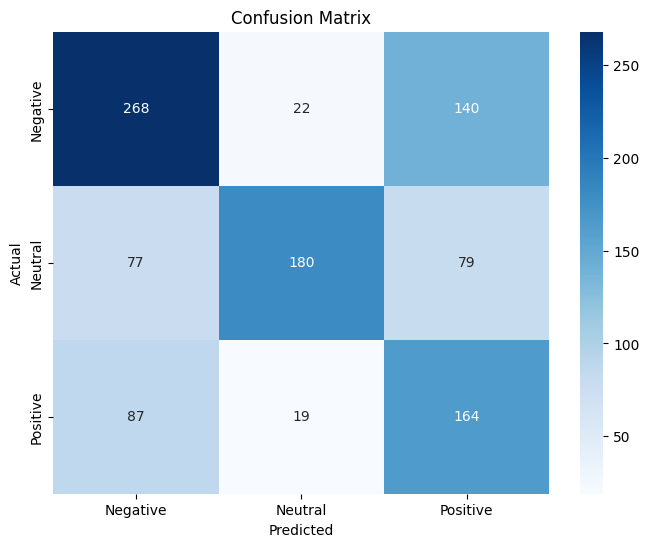

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)  # Get the index of the highest logit

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## LDA Implementation

In [16]:
!pip install gensim pyLDAvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 27.9 MB/s eta 0:00:00


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(0, '0.055*"india" + 0.022*"job" + 0.017*"recession" + 0.015*"economy" + 0.014*"global" + 0.014*"growth" + 0.014*"time" + 0.012*"tough" + 0.012*"economic" + 0.011*"157"')
(1, '0.027*"क" + 0.017*"need" + 0.011*"ह" + 0.010*"million" + 0.009*"lose" + 0.009*"म" + 0.008*"lol" + 0.007*"gold" + 0.007*"मद" + 0.006*"key"')
(2, '0.011*"enter" + 0.010*"celebrate" + 0.009*"2020" + 0.009*"india" + 0.008*"rupee" + 0.007*"soon" + 0.007*"true" + 0.006*"bric" + 0.006*"fiscal" + 0.006*"take"')
(3, '0.079*"india" + 0.028*"recession" + 0.021*"prospect" + 0.020*"china" + 0.020*"amp" + 0.015*"edition" + 0.012*"world" + 0.008*"global" + 0.007*"150" + 0.007*"govt"')
(4, '0.036*"rt" + 0.017*"car" + 0.016*"india" + 0.013*"grow" + 0.010*"cheapest" + 0.009*"beat" + 0.009*"news" + 0.009*"2008" + 0.009*"nano" + 0.009*"d"')

Coherence Score:  0.519292272918933


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


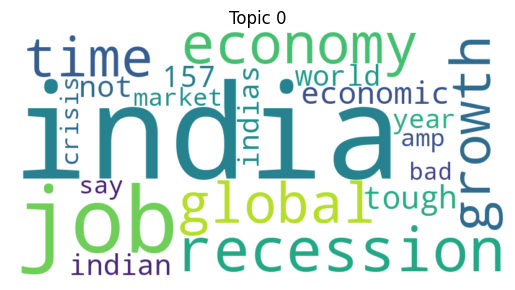

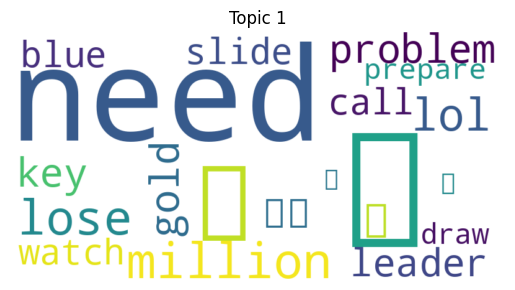

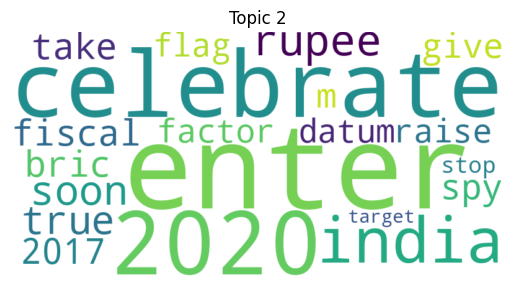

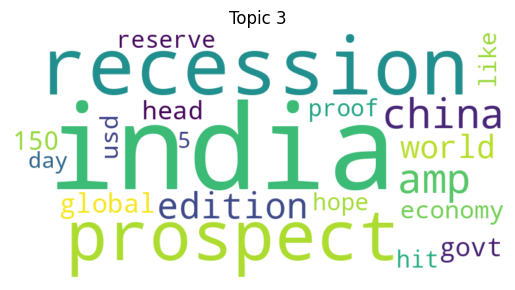

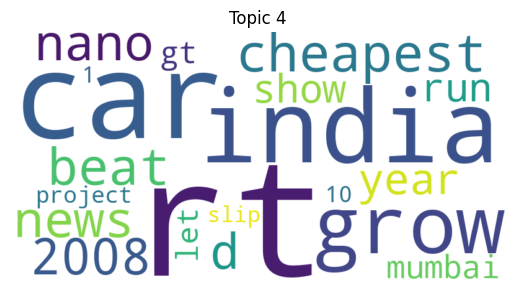

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


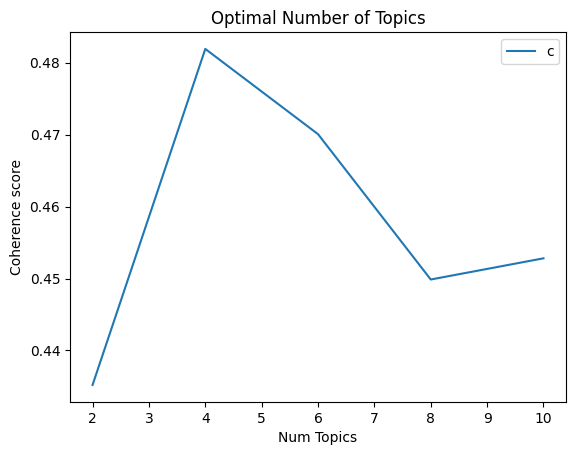

In [17]:
import pandas as pd
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from wordcloud import WordCloud

# Assuming `df['lemmatized_content']` is your lemmatized text data
texts = df['lemmatized_content'].apply(lambda x: x.split()).tolist()

# Create Dictionary
id2word = corpora.Dictionary(texts)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5,  # Choose the number of topics
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

# Print the Keyword in the topics
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

# Generate WordCloud for each topic
for i, topic in lda_model.show_topics(formatted=False, num_words=20):
    topic_words = dict(topic)
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Topic {i}")
    plt.show()

# Optimal number of topics: Topic Coherence Score graph
coherence_values = []
model_list = []
for num_topics in range(2, 12, 2):
    model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

# Show graph
x = range(2, 12, 2)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend("coherence_values", loc='best')
plt.title("Optimal Number of Topics")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top N words for each topic:
Topic 0: india job recession time global tough growth economic economy 157
Topic 1: क need ह million lose म lol gold मद key
Topic 2: india enter celebrate 2020 rupee soon gdp true bric fiscal
Topic 3: india recession prospect china world amp edition economy global gdp
Topic 4: rt car india tata cheapest nano beat news 2008 grow


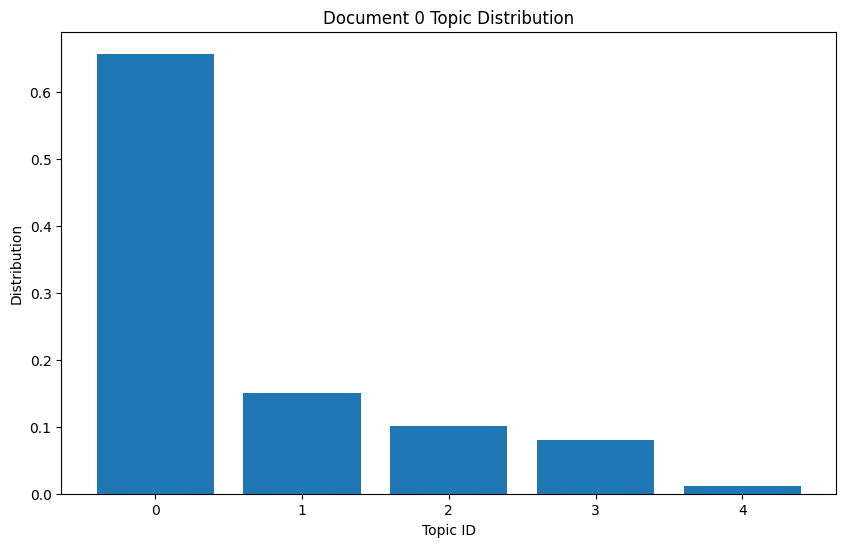

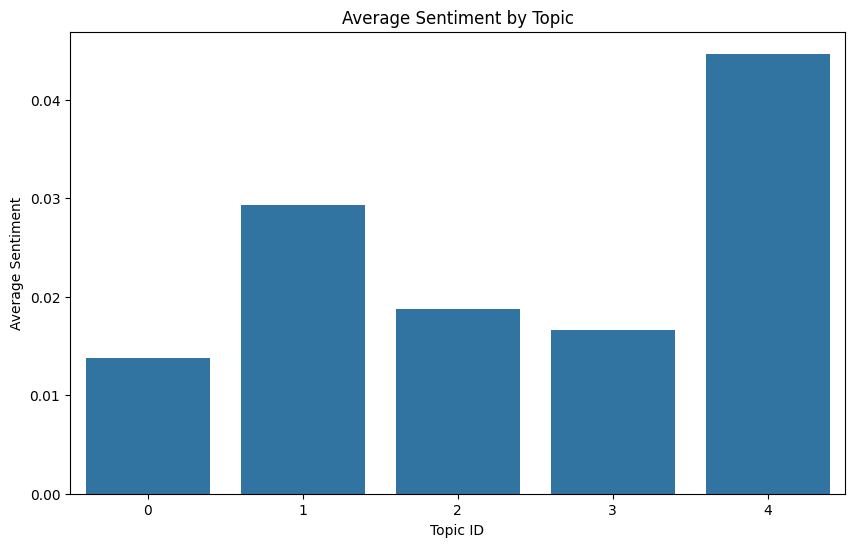

In [20]:
import pandas as pd
import gensim
from gensim import corpora
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from textblob import TextBlob

# Assuming `df` contains 'lemmatized_content', 'sentiment_label', and 'publication_date' or other metadata columns

# Step 1: Data Preparation
texts = df['lemmatized_content'].apply(lambda x: x.split()).tolist()
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Step 2: Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=5, random_state=42, chunksize=100, passes=10, per_word_topics=True)

# Step 3: Topic Interpretation - Top N Words Analysis
top_n = 10
topics = lda_model.show_topics(num_topics=5, num_words=top_n, formatted=False)
topic_words = {i: [word for word, _ in words] for i, words in topics}

# Display Top N Words per Topic
print("Top N words for each topic:")
for topic_id, words in topic_words.items():
    print(f"Topic {topic_id}: {' '.join(words)}")

# Step 4: Document Topic Distribution
# Get the dominant topic for each document
dominant_topics = []
topic_distributions = []
for row in lda_model[corpus]:
    row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    dominant_topic = row[0][0]
    dominant_topics.append(dominant_topic)
    topic_distributions.append([prob for _, prob in row])

df['dominant_topic'] = dominant_topics
df['topic_distribution'] = topic_distributions

# Reset index to ensure it is integer-based
df.reset_index(drop=True, inplace=True)

# Visualize Topic Distribution for a Sample Document
sample_doc_id = 0  # You can change this index for different documents

# Accessing by position using .iloc[]
if sample_doc_id < len(df):
    sample_topic_dist = df.iloc[sample_doc_id]['topic_distribution']
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sample_topic_dist)), sample_topic_dist)
    plt.xlabel('Topic ID')
    plt.ylabel('Distribution')
    plt.title(f'Document {sample_doc_id} Topic Distribution')
    plt.show()
else:
    print(f"Document ID {sample_doc_id} is out of bounds for the DataFrame.")

# Step 5: Sentiment Analysis by Topic
df['sentiment'] = df['lemmatized_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group by dominant topic and calculate mean sentiment
sentiment_by_topic = df.groupby('dominant_topic')['sentiment'].mean().reset_index()

# Visualize Sentiment by Topic
plt.figure(figsize=(10, 6))
sns.barplot(x='dominant_topic', y='sentiment', data=sentiment_by_topic)
plt.xlabel('Topic ID')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Topic')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Top N words for each topic:
Topic 0: india tough economic industry new blog slowdown well know read
Topic 3: india recession economy world global china amp not edition like
Topic 4: beat d 2020 run avoid hai week guy tackle bubble
Topic 9: brazil sale mumbai key land raise number plunge emerge rating
Topic 1: job क help hope ह million lose म sector deep


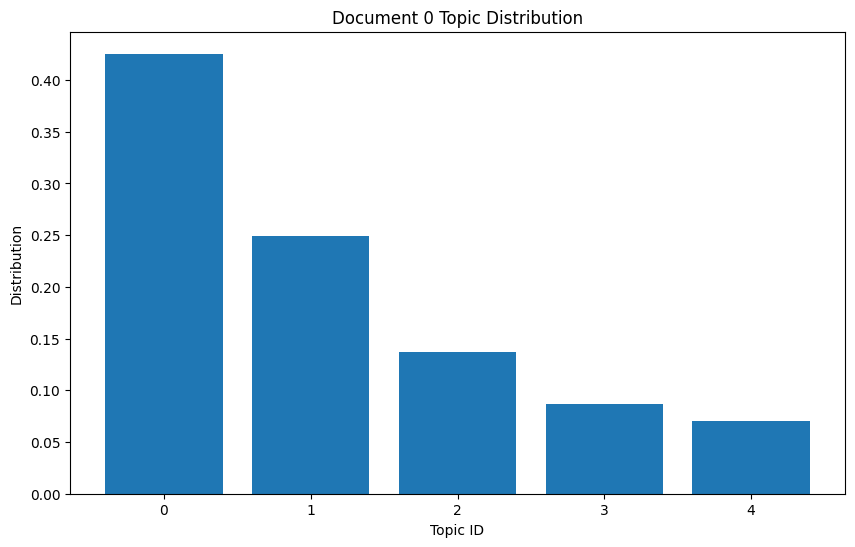

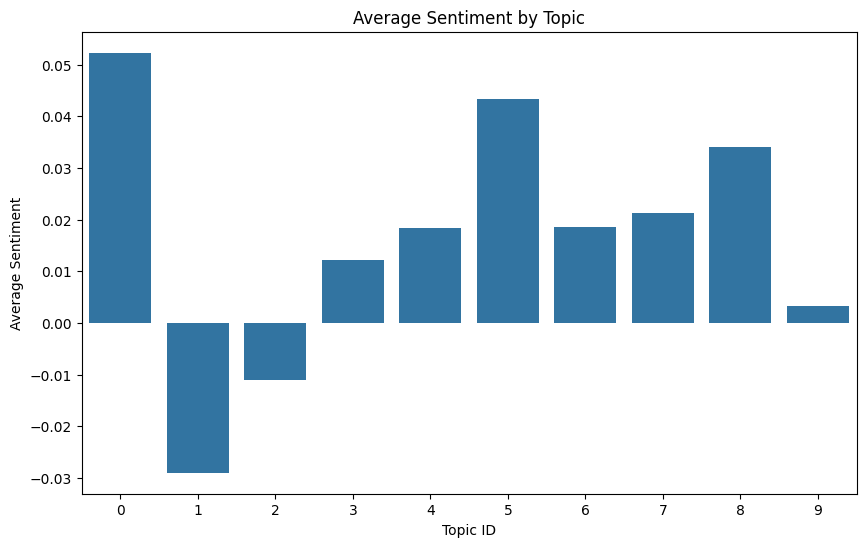

No 'publication_date' column found for trend analysis.
No 'author' column found for metadata correlation analysis.


In [22]:
import pandas as pd
import gensim
from gensim import corpora
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from wordcloud import WordCloud
from textblob import TextBlob
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Assuming `df` contains 'lemmatized_content', 'sentiment_label', and 'publication_date' or other metadata columns

# Step 1: Data Preparation
texts = df['lemmatized_content'].apply(lambda x: x.split()).tolist()
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

# Step 2: Build LDA Model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=10, random_state=42, chunksize=100, passes=10, per_word_topics=True)

# Step 3: Topic Interpretation - Top N Words Analysis
top_n = 10
topics = lda_model.show_topics(num_topics=5, num_words=top_n, formatted=False)
topic_words = {i: [word for word, _ in words] for i, words in topics}

# Display Top N Words per Topic
print("Top N words for each topic:")
for topic_id, words in topic_words.items():
    print(f"Topic {topic_id}: {' '.join(words)}")

# Step 4: Document Topic Distribution
# Get the dominant topic for each document
dominant_topics = []
topic_distributions = []
for row in lda_model[corpus]:
    row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
    dominant_topic = row[0][0]
    dominant_topics.append(dominant_topic)
    topic_distributions.append([prob for _, prob in row])

df['dominant_topic'] = dominant_topics
df['topic_distribution'] = topic_distributions

# Reset index to ensure it is integer-based
df.reset_index(drop=True, inplace=True)

# Visualize Topic Distribution for a Sample Document
sample_doc_id = 0  # You can change this index for different documents

# Accessing by position using .iloc[]
if sample_doc_id < len(df):
    sample_topic_dist = df.iloc[sample_doc_id]['topic_distribution']
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(sample_topic_dist)), sample_topic_dist)
    plt.xlabel('Topic ID')
    plt.ylabel('Distribution')
    plt.title(f'Document {sample_doc_id} Topic Distribution')
    plt.show()
else:
    print(f"Document ID {sample_doc_id} is out of bounds for the DataFrame.")

# Step 5: Sentiment Analysis by Topic
df['sentiment'] = df['lemmatized_content'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Group by dominant topic and calculate mean sentiment
sentiment_by_topic = df.groupby('dominant_topic')['sentiment'].mean().reset_index()

# Visualize Sentiment by Topic
plt.figure(figsize=(10, 6))
sns.barplot(x='dominant_topic', y='sentiment', data=sentiment_by_topic)
plt.xlabel('Topic ID')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Topic')
plt.show()

# Step 6: Trend Analysis (if time-series data is available)
# Convert 'publication_date' to datetime if necessary
if 'publication_date' in df.columns:
    df['publication_date'] = pd.to_datetime(df['publication_date'])

    # Group by publication date and dominant topic
    df['date'] = df['publication_date'].dt.to_period('M')
    topic_trends = df.groupby(['date', 'dominant_topic']).size().unstack(fill_value=0)

    # Normalize trends for better visualization
    topic_trends = topic_trends.apply(lambda x: x / x.sum(), axis=1)

    # Plot Topic Trends Over Time
    plt.figure(figsize=(14, 8))
    topic_trends.plot()
    plt.xlabel('Date')
    plt.ylabel('Topic Proportion')
    plt.title('Topic Trends Over Time')
    plt.show()
else:
    print("No 'publication_date' column found for trend analysis.")

# Step 7: Correlation with Metadata (e.g., author or publication)
if 'author' in df.columns:
    topic_by_author = df.groupby(['author', 'dominant_topic']).size().unstack(fill_value=0)
    topic_by_author_norm = normalize(topic_by_author, axis=1, norm='l1')  # Normalize rows

    # Visualize as Heatmap
    plt.figure(figsize=(14, 10))
    sns.heatmap(topic_by_author_norm, cmap='Blues', annot=False)
    plt.xlabel('Topic ID')
    plt.ylabel('Author')
    plt.title('Topic Distribution by Author')
    plt.show()
else:
    print("No 'author' column found for metadata correlation analysis.")

# Step 8: Interactive Visualization with pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)

# Optionally, you can save the interactive visualization as an HTML file:
# pyLDAvis.save_html(vis, 'lda_visualization.html')